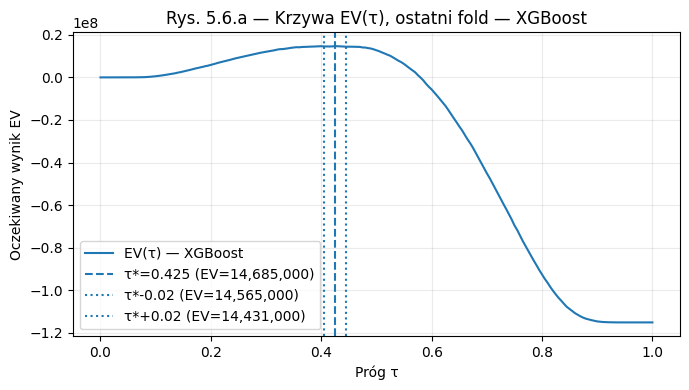

Zapisano wykres: C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts\podsumowanie_wyników\Rys_56a_EV_curve_prod.png


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path(r"C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts")
ART_GBM = ROOT / "artifacts_46_gbm"
OUTDIR  = ROOT / "podsumowanie_wyników"
OUTDIR.mkdir(parents=True, exist_ok=True)

# Wybór modelu produkcyjnego
if (ART_GBM / "profit_curve_last_fold_xgb.csv").exists():
    prod_name, suf = "XGBoost", "xgb"
else:
    prod_name, suf = "LightGBM", "lgb"

pc = pd.read_csv(ART_GBM / f"profit_curve_last_fold_{suf}.csv")  # kolumny: tau, expected_profit
tau_star = float(pc.loc[pc.expected_profit.idxmax(), "tau"])
ev_star  = float(pc["expected_profit"].max())
tau_minus = max(0.0, tau_star - 0.02)
tau_plus  = min(1.0, tau_star + 0.02)

# Interpolacja EV dla ±0.02 (na potrzeby adnotacji)
ev_minus = float(np.interp(tau_minus, pc["tau"].values, pc["expected_profit"].values))
ev_plus  = float(np.interp(tau_plus , pc["tau"].values, pc["expected_profit"].values))

plt.figure(figsize=(7,4))
plt.plot(pc["tau"], pc["expected_profit"], label=f"EV(τ) — {prod_name}")
plt.axvline(tau_star,  ls="--", label=f"τ*={tau_star:.3f} (EV={ev_star:,.0f})")
plt.axvline(tau_minus, ls=":",  label=f"τ*-0.02 (EV={ev_minus:,.0f})")
plt.axvline(tau_plus,  ls=":",  label=f"τ*+0.02 (EV={ev_plus:,.0f})")
plt.xlabel("Próg τ")
plt.ylabel("Oczekiwany wynik EV")
plt.title(f"Rys. 5.6.a — Krzywa EV(τ), ostatni fold — {prod_name}")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()

out_png = OUTDIR / "Rys_56a_EV_curve_prod.png"
plt.savefig(out_png, dpi=200)
plt.show()

print(f"Zapisano wykres: {out_png}")


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

# === 0) ŚCIEŻKI ===
ROOT = Path(r"C:\Users\lukasz.wrobel\Desktop\PRACA MAGISTERSKA\pliki\artifacts")
ART_GBM = ROOT / "artifacts_46_gbm"
OUTDIR  = ROOT / "podsumowanie_wyników"
OUTDIR.mkdir(parents=True, exist_ok=True)

# artefakty XGB/LGB – wybór modelu produkcyjnego
CANDIDATES = [
    ("XGBoost", "xgb"),
    ("LightGBM", "lgb"),
]
prod_name, suf = None, None
for name, s in CANDIDATES:
    if (ART_GBM / f"profit_curve_last_fold_{s}.csv").exists() and \
       (ART_GBM / f"decision_summary_oot_{s}.csv").exists():
        prod_name, suf = name, s
        break
assert prod_name is not None, "Brak artefaktów XGB/LGBM w artifacts_46_gbm."

# === 1) Krzywa EV(τ) i wrażliwość ±0.02 ===
pc = pd.read_csv(ART_GBM / f"profit_curve_last_fold_{suf}.csv")
# plik ma kolumny: tau, expected_profit
tau_star = float(pc.loc[pc.expected_profit.idxmax(), "tau"])
ev_star  = float(pc["expected_profit"].max())

def ev_at(t):
    # interpolacja liniowa na siatce τ
    return float(np.interp(t, pc["tau"].values, pc["expected_profit"].values))

ev_minus = ev_at(max(0.0, tau_star-0.02))
ev_plus  = ev_at(min(1.0, tau_star+0.02))

sens = pd.DataFrame({
    "model":[prod_name],
    "tau_star":[tau_star],
    "EV_star":[ev_star],
    "EV_tau_minus_0.02":[ev_minus],
    "EV_tau_plus_0.02":[ev_plus],
    "delta_minus":[ev_minus-ev_star],
    "delta_plus":[ev_plus-ev_star]
})
sens.to_csv(OUTDIR / "Tabela_56_sensytywnosc_tau.csv", index=False)

# === 2) Tabela 5.6 – decyzja przy τ* na OOT ===
# podsumowanie OOT (accepted_cnt, TG, TB, EV)
dec = pd.read_csv(ART_GBM / f"decision_summary_oot_{suf}.csv", header=None, names=["key","val"])
kv  = dict(zip(dec["key"], dec["val"]))
accepted = int(kv["accepted_cnt"])
tg = int(kv["true_good_accepted"])
tb = int(kv["true_bad_accepted"])
ev_oot = int(kv["expected_profit_OOT"])
tau_star_oot = float(kv["best_tau_from_valid"])

# liczność OOT z tabeli decylowej
decile = pd.read_csv(ART_GBM / f"decile_table_oot_{suf}.csv")
N_oot = int(decile["n"].sum())

tbl = pd.DataFrame({
    "model":[prod_name],
    "tau_star":[tau_star_oot],
    "N_OOT":[N_oot],
    "accepted_cnt":[accepted],
    "acceptance_rate":[accepted / N_oot if N_oot else np.nan],
    "TG":[tg],
    "TB":[tb],
    "bad_rate_accepted":[tb / accepted if accepted else np.nan],
    "EV_OOT":[ev_oot]
})
tbl.to_csv(OUTDIR / "Tabela_56_decyzja_przy_tau_star.csv", index=False)

print(f"Model produkcyjny: {prod_name}")
print(tbl)
print("\nWrażliwość EV wokół τ*:")
print(sens)


Model produkcyjny: XGBoost
     model  tau_star  N_OOT  accepted_cnt  acceptance_rate    TG    TB  \
0  XGBoost     0.425  12477         10422         0.835297  7920  2502   

   bad_rate_accepted   EV_OOT  
0           0.240069 -4590000  

Wrażliwość EV wokół τ*:
     model  tau_star     EV_star  EV_tau_minus_0.02  EV_tau_plus_0.02  \
0  XGBoost     0.425  14685000.0         14565000.0        14431000.0   

   delta_minus  delta_plus  
0    -120000.0   -254000.0  
